## Preparation

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline  
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectFpr, f_classif, chi2
from sklearn.metrics import precision_score
from xgboost import XGBClassifier
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency

In [78]:
data = pd.read_csv('ifood_df.csv') 

In [79]:
data.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,0,0,0,1,0,0,1529,1441,0
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,0,0,0,1,0,0,21,15,0
2,71613.0,0,0,26,426,49,127,111,21,42,...,1,0,0,0,1,0,0,734,692,0
3,26646.0,1,0,26,11,4,20,10,3,5,...,1,0,0,0,1,0,0,48,43,0
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,0,0,0,0,0,1,407,392,0


In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Income                2205 non-null   float64
 1   Kidhome               2205 non-null   int64  
 2   Teenhome              2205 non-null   int64  
 3   Recency               2205 non-null   int64  
 4   MntWines              2205 non-null   int64  
 5   MntFruits             2205 non-null   int64  
 6   MntMeatProducts       2205 non-null   int64  
 7   MntFishProducts       2205 non-null   int64  
 8   MntSweetProducts      2205 non-null   int64  
 9   MntGoldProds          2205 non-null   int64  
 10  NumDealsPurchases     2205 non-null   int64  
 11  NumWebPurchases       2205 non-null   int64  
 12  NumCatalogPurchases   2205 non-null   int64  
 13  NumStorePurchases     2205 non-null   int64  
 14  NumWebVisitsMonth     2205 non-null   int64  
 15  AcceptedCmp3         

## Data Cleaning and Visualisation

In [81]:
# distinguish categorical columns and numerical columns for data visualisation
categorical_columns = []
numerical_columns = []
for column in data.columns:
    if column == 'Response':  
        continue
    elif len(sorted(data[column].unique())) == 1: 
        continue
    elif column in ['MntTotal','MntRegularProds','AcceptedCmpOverall']: 
        continue
    elif len(sorted(data[column].unique())) <= 10: 
        categorical_columns.append(column)
    else:
        numerical_columns.append(column)

categorical_columns, numerical_columns

(['Kidhome',
  'Teenhome',
  'AcceptedCmp3',
  'AcceptedCmp4',
  'AcceptedCmp5',
  'AcceptedCmp1',
  'AcceptedCmp2',
  'Complain',
  'marital_Divorced',
  'marital_Married',
  'marital_Single',
  'marital_Together',
  'marital_Widow',
  'education_2n Cycle',
  'education_Basic',
  'education_Graduation',
  'education_Master',
  'education_PhD'],
 ['Income',
  'Recency',
  'MntWines',
  'MntFruits',
  'MntMeatProducts',
  'MntFishProducts',
  'MntSweetProducts',
  'MntGoldProds',
  'NumDealsPurchases',
  'NumWebPurchases',
  'NumCatalogPurchases',
  'NumStorePurchases',
  'NumWebVisitsMonth',
  'Age',
  'Customer_Days'])

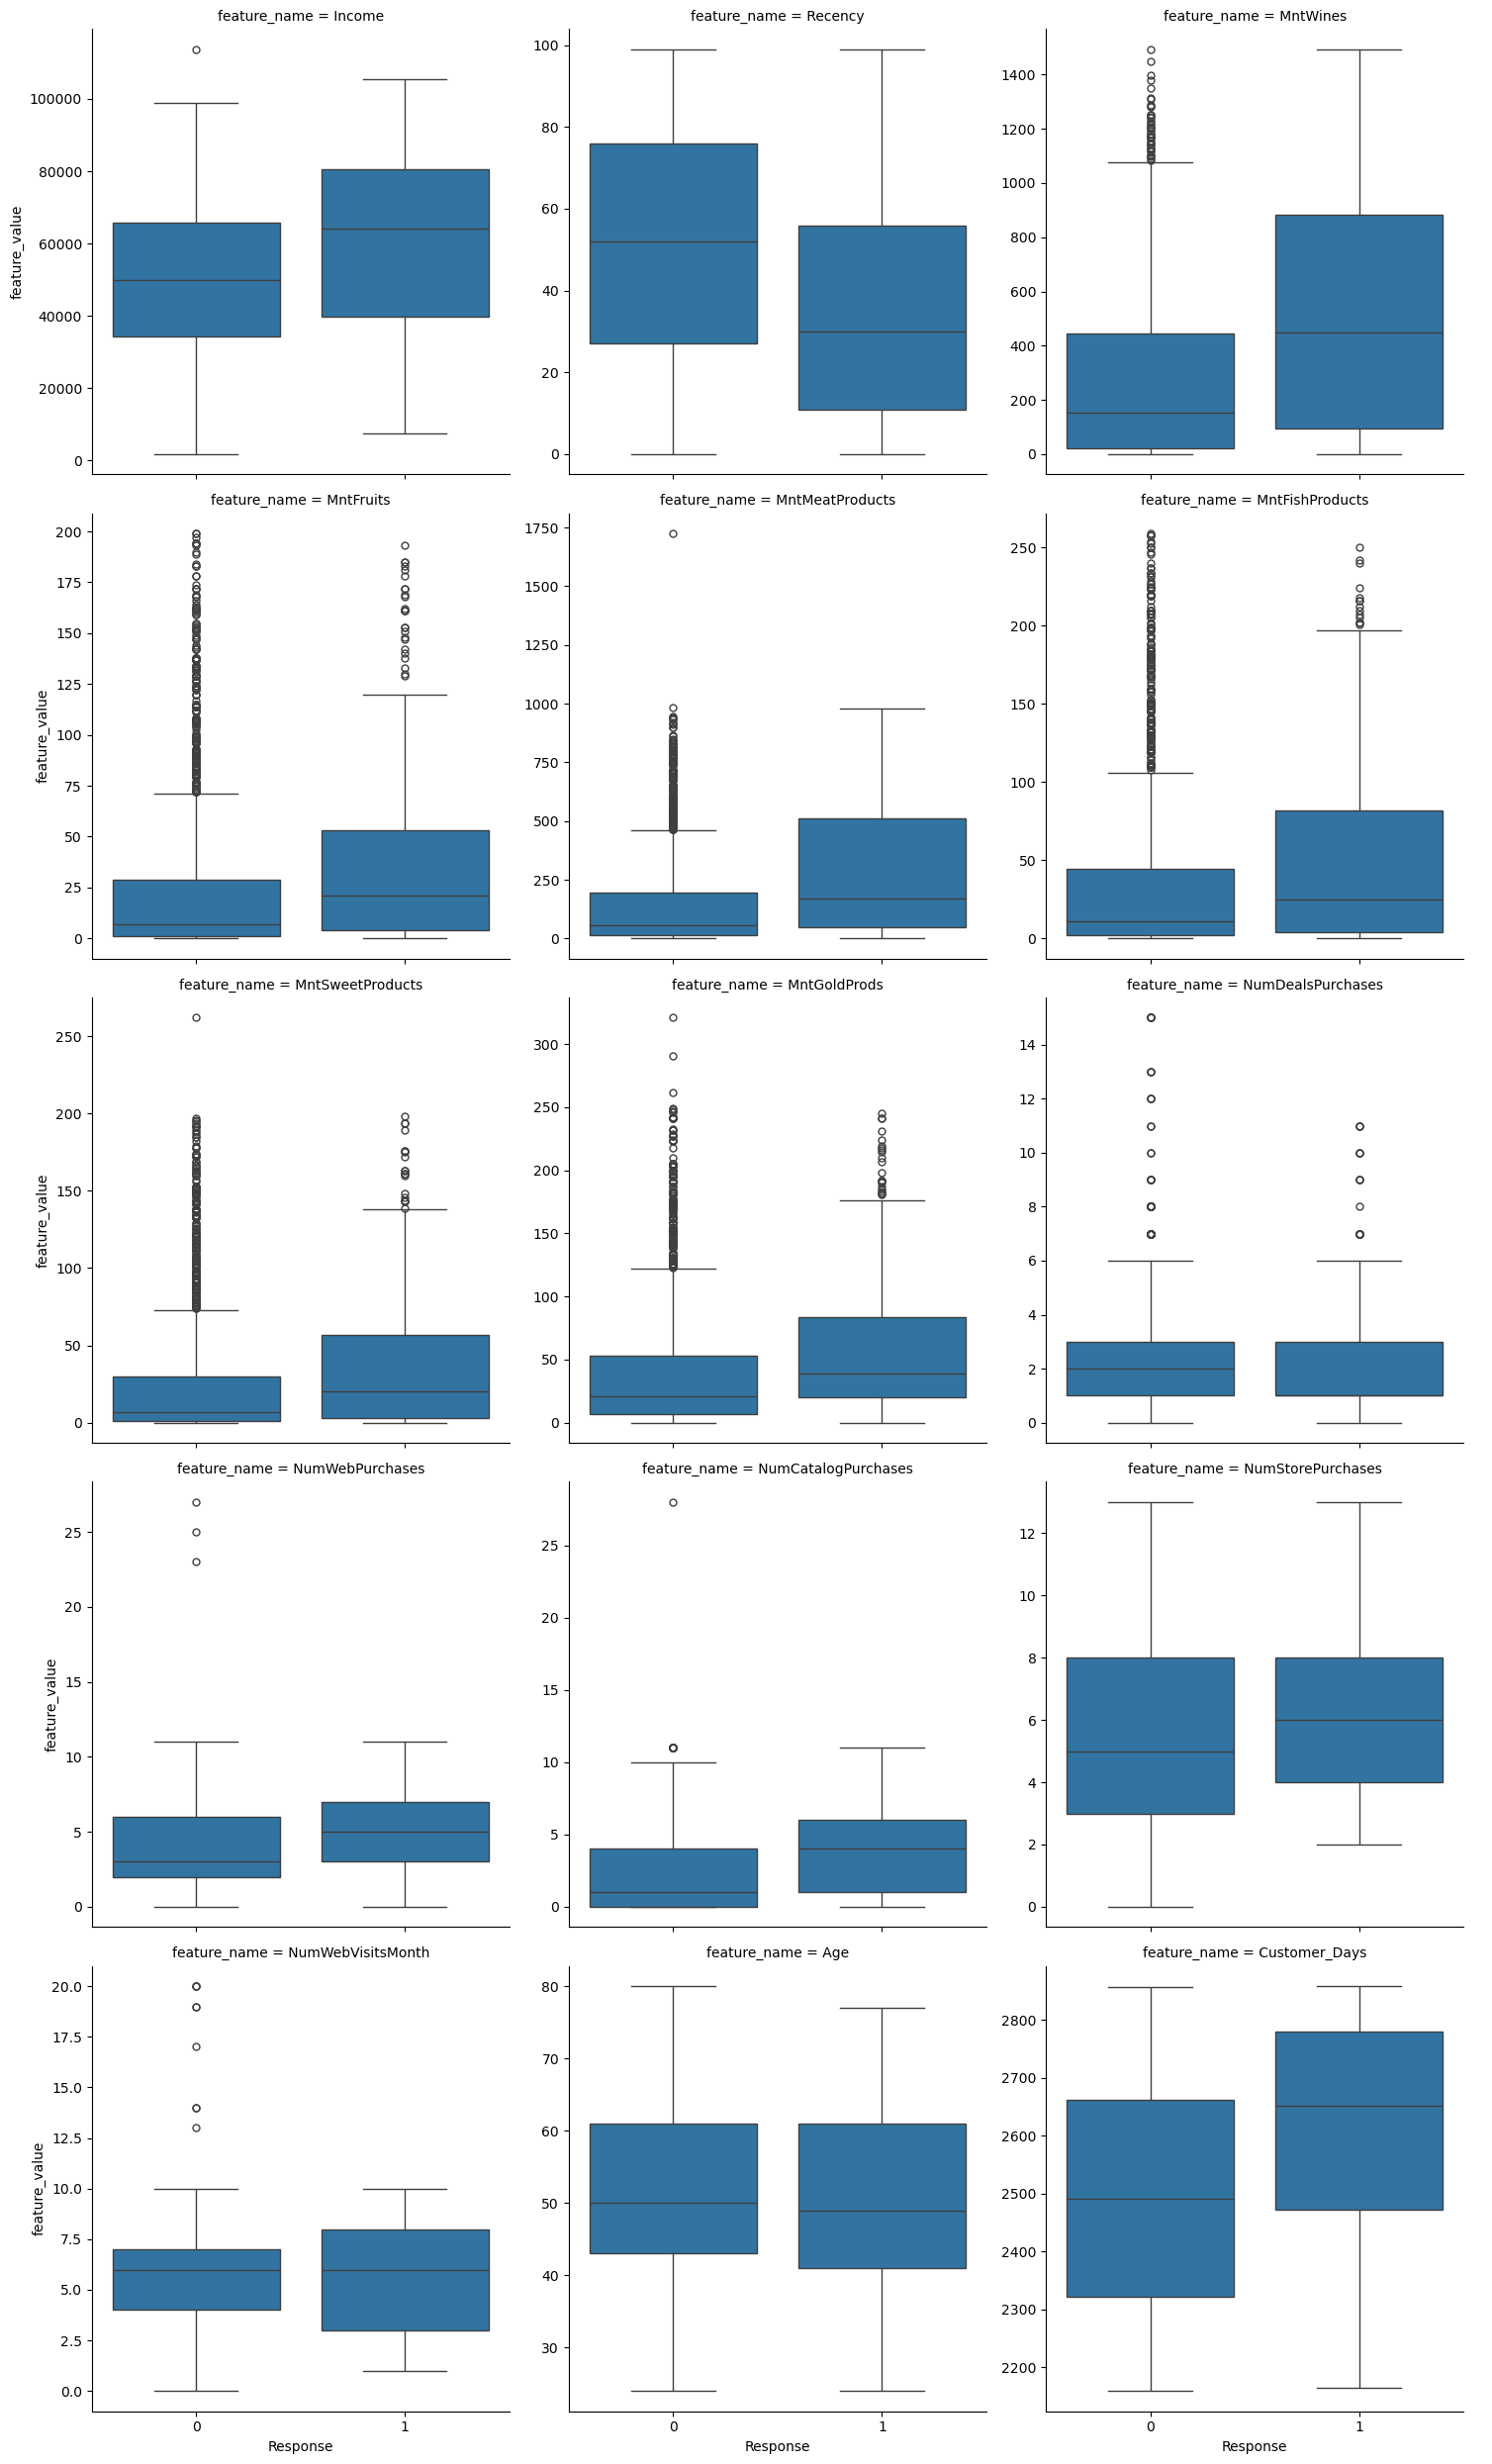

In [82]:
# Box plot for the distribution of numerical features
data_melted = data[numerical_columns + ['Response']].melt(id_vars='Response', value_vars=numerical_columns, 
                        var_name='feature_name', value_name='feature_value')

sns.catplot(kind='box', data=data_melted, x='Response', y='feature_value', col='feature_name', col_wrap=3, sharey=False)

Customers with Response = 1 tend to have: 
* Higher income
* Lower recency (their last purchase is more recennt)
* Higher customer_days (have been customers for a longer time)
* More frequent purchases on different things

The features that don't have strong correlation with the response are: 
* Purchase channels
* Age

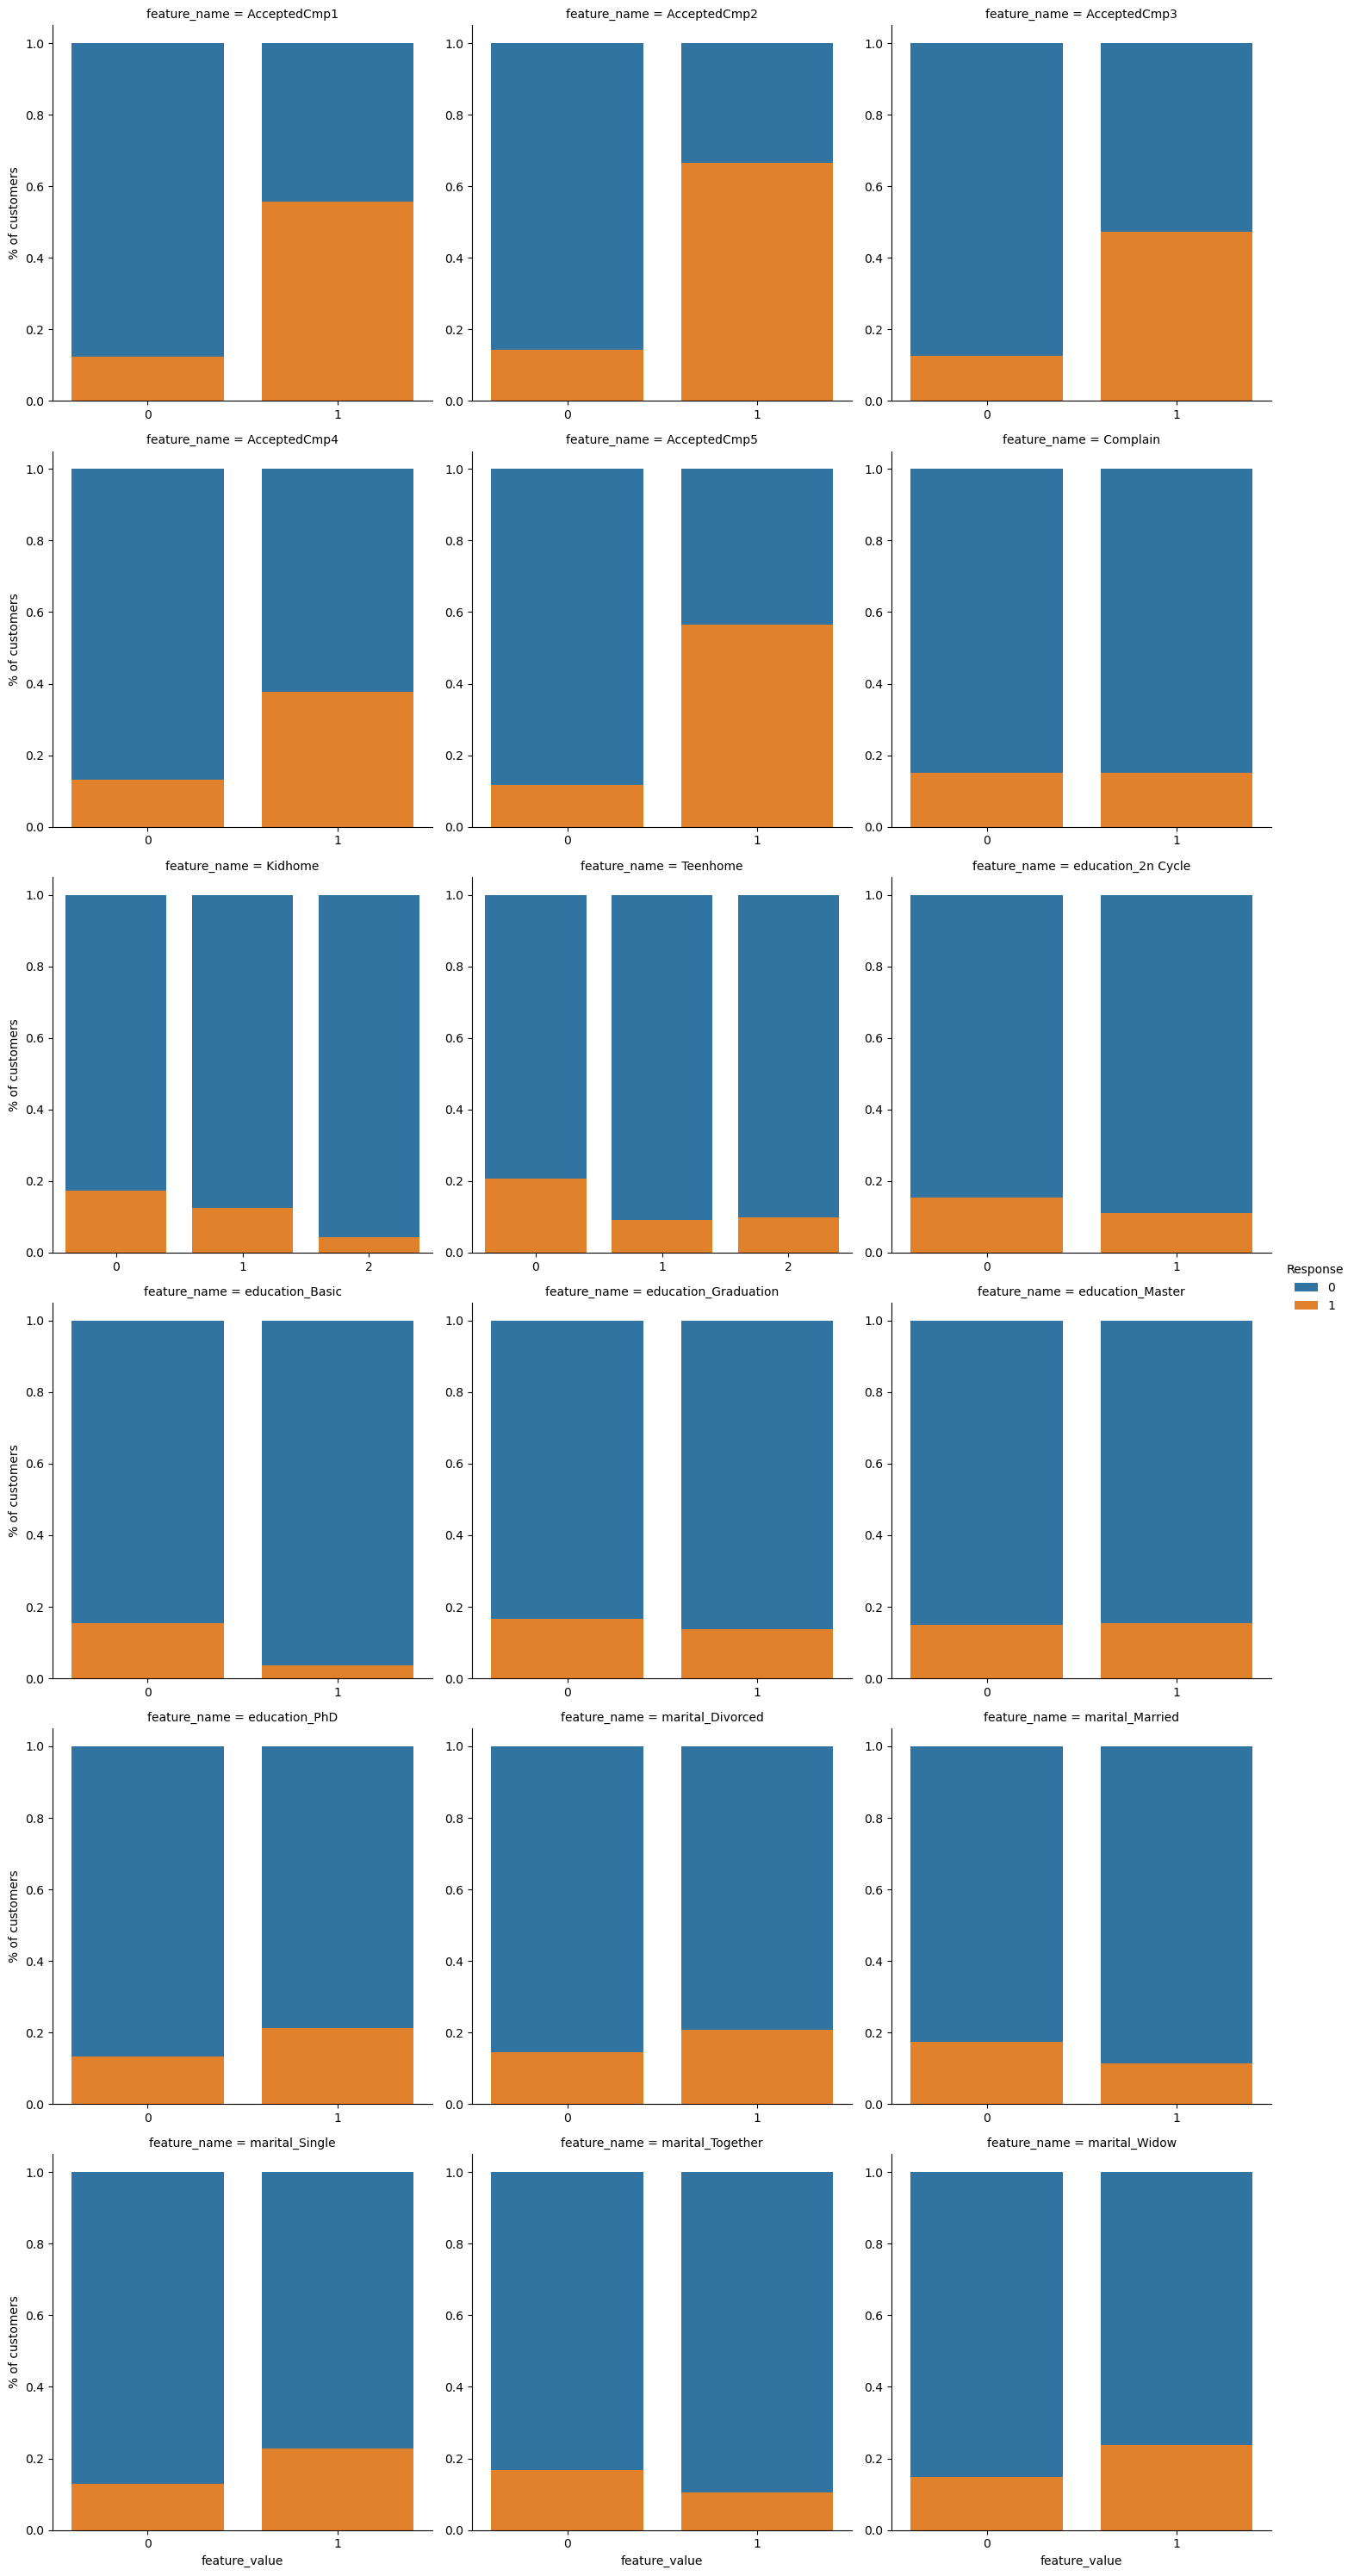

In [83]:
# Bar chart for the distribution of categorical features

data_melted = data[categorical_columns + ['Response']].melt(id_vars='Response', value_vars=categorical_columns, 
                        var_name='feature_name', value_name='feature_value')
data_melted['count'] = 1


data_melted = data_melted.groupby(['feature_name','feature_value','Response'])[['count']].sum().reset_index(names=['feature_name','feature_value','Response'])
data_melted.sort_values(['feature_name','feature_value','Response'], ascending=[True,True,False],inplace=True) 
data_grouped_total = data_melted.groupby(['feature_name','feature_value'])[['count']].sum().reset_index(names=['feature_name','feature_value'])
data_melted = data_melted.merge(data_grouped_total, on=['feature_name','feature_value'])
data_melted['pctg_count'] = data_melted['count_x'] / data_melted['count_y']
data_melted['% of customers'] = data_melted.groupby(['feature_name','feature_value']).rolling(2, min_periods=1).sum()['pctg_count'].values


sns.catplot(kind='bar', data=data_melted, x='feature_value', y='% of customers', hue='Response', col='feature_name', col_wrap=3, sharey=False, sharex=False, estimator='sum', dodge=False)

Customers with Response = 1 tend to: 
* have accepted previous campaigns
* have no children and teens
* not have a partner (divorced, single, or widow)

The features that don't have strong correlation with the response are: 
* Complain

Education is a bit complicated, since people without a basic education level can have a higher response rate than those who don't and people with PHD degree can have a higher response rate than those who don't.

Generally, a customer with a higher response rate should: 
* have a high income level and spends frequently and recently
* have been a customer for a long time
* have responded to previous campaigns
* not have children or partner

## Identify Features Correlated with the Response
Using ANOVA for numerical features and Chi-squared tests of independence for categorical features

In [84]:
# ANOVA
result = []
for c in numerical_columns:
    negative_response = data[data['Response'] == 0][c].values
    positive_response = data[data['Response'] == 1][c].values
    p_value = f_oneway(negative_response, positive_response).pvalue
    result.append([c, p_value])

pd.DataFrame(result, columns=['feature', 'p-value']).sort_values('p-value', ascending=True)

,feature,p-value
4,MntMeatProducts,1.810731e-32
2,MntWines,1.216773e-31
10,NumCatalogPurchases,6.226722e-29
1,Recency,2.056815e-21
14,Customer_Days,1.233380e-20
0,Income,1.315994e-16
9,NumWebPurchases,1.601998e-12
7,MntGoldProds,3.770096e-11
3,MntFruits,8.274588e-09
6,MntSweetProducts,5.621113e-08


The story is similar with the visualisation's. The top rows, numerical features with lower p-values, have higher correlation with the response.

In [85]:
# Chi-squared
result = []
for c in categorical_columns:
    contingency_table = pd.crosstab(data[c], data['Response'])
    p_value = chi2_contingency(contingency_table).pvalue # Perform Chi-squared test
    result.append([c, p_value])

pd.DataFrame(result, columns=['feature', 'p-value']).sort_values('p-value', ascending=True)

,feature,p-value
4,AcceptedCmp5,1.021640e-51
5,AcceptedCmp1,1.822433e-43
2,AcceptedCmp3,4.210775e-32
3,AcceptedCmp4,8.348030e-17
6,AcceptedCmp2,1.528330e-14
1,Teenhome,2.524076e-13
10,marital_Single,1.386801e-07
17,education_PhD,3.528371e-05
9,marital_Married,1.990126e-04
11,marital_Together,5.859672e-04


The story is similar with the visualisation's. The top rows, categorical features with lower p-values, have higher correlation with the response.

## Data Modeling

In [86]:
# Deal with imbalance
rawdata = data[numerical_columns + categorical_columns + ['Response']]
X_train, X_test, y_train, y_test = train_test_split(rawdata.drop('Response', axis=1), rawdata['Response'], test_size=0.2, random_state=1)
print(y_train.mean(), y_test.mean())

0.15306122448979592 0.14285714285714285


In [87]:



num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numerical_columns),
    ('cat', cat_pipe, categorical_columns)
], remainder='drop')   


pipe = ImbPipeline([
    ('prep', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=200))
])


grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring='precision',
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)  



,estimator,Pipeline(step...x_iter=200))])
,param_grid,"[{'model': [LogisticRegression(), RandomForestClassifier(), ...]}]"
,scoring,'precision'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [88]:
from sklearn.preprocessing import OneHotEncoder

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ],
    remainder='passthrough'
)


In [89]:
# Baseline model
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('model', None)
])

param_grid = [{
    'model': [LogisticRegression(), RandomForestClassifier(), XGBClassifier()]
}]

grid = GridSearchCV(pipe, param_grid=param_grid, scoring=['accuracy','precision','recall','f1','roc_auc'], refit='precision')
grid.fit(X_train, y_train)
results = pd.DataFrame(grid.cv_results_).sort_values('rank_test_precision')
results[['param_model','params'] + [x for x in results.columns if 'mean_test' in x]]

,param_model,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
0,LogisticRegression(),{'model': LogisticRegression()},0.896816,0.740254,0.508380,0.601074,0.905105
1,RandomForestClassifier(),{'model': RandomForestClassifier()},0.878686,0.716733,0.345097,0.458889,0.892415
2,"XGBClassifier(base_score=None, booster=None, c...","{'model': XGBClassifier(base_score=None, boost...",0.882076,0.663333,0.465537,0.545241,0.900569


The precision (proportion of true predictions being actually true) is satisfying, reaching nearly 73% for random forest model. This is what we should care about because we want to maximize the response rate.

In [90]:
# Improve the model by defining a general purpose transformer
class GeneralTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, expr, feature_name_out='Undefined'):
        self.expr = expr
        self.feature_name_out = feature_name_out
    
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['result'] = X_copy.apply(lambda x: eval(self.expr), axis=1)
        return X_copy[['result']]
    
    def get_feature_names_out(self, input_features=None): 
        return np.array([self.feature_name_out])

In [91]:
# Combine all marital status features into 1 (have a partner or not)
is_single_columns = ['marital_Single','marital_Divorced','marital_Widow','marital_Married','marital_Together']

pipe = Pipeline([
    ('preprocessing', ColumnTransformer([
        ('categorical', ColumnTransformer([('is_Single',GeneralTransformer(expr='1 if x.iloc[0] == 1 or x.iloc[1] == 1 or x.iloc[2] == 1 else 0'), is_single_columns)], remainder='passthrough'), categorical_columns),
        ('numerical', StandardScaler(), numerical_columns)
    ])),
    ('model', None)
])

param_grid = [{
    'model': [LogisticRegression(), RandomForestClassifier(), XGBClassifier()]
}]

grid = GridSearchCV(pipe, param_grid=param_grid, scoring=['accuracy','precision','recall','f1','roc_auc'], refit='precision')
grid.fit(X_train, y_train)
results = pd.DataFrame(grid.cv_results_).sort_values('rank_test_precision')
results[['param_model','params'] + [x for x in results.columns if 'mean_test' in x]]

,param_model,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
1,RandomForestClassifier(),{'model': RandomForestClassifier()},0.878686,0.737772,0.322688,0.445982,0.895052
0,LogisticRegression(),{'model': LogisticRegression()},0.894552,0.730503,0.496500,0.590064,0.908532
2,"XGBClassifier(base_score=None, booster=None, c...","{'model': XGBClassifier(base_score=None, boost...",0.883783,0.667813,0.483489,0.558833,0.904263


Precision overall slightly improved. The model with best performance is now logistic regress, with a precision of 73.05%. The model also become more lightweight.

In [92]:
# Combine all children columns into one (have children/teens or not)
is_single_columns = ['marital_Single','marital_Divorced','marital_Widow','marital_Married','marital_Together']
has_children_columns = ['Kidhome','Teenhome']

pipe = Pipeline([
    ('preprocessing', ColumnTransformer([
        ('categorical', ColumnTransformer([('is_Single',GeneralTransformer(expr='1 if x.iloc[0] == 1 or x.iloc[1] == 1 or x.iloc[2] == 1 else 0'), is_single_columns),
                                           ('has_Children',GeneralTransformer(expr='1 if x.iloc[0] == 0 and x.iloc[1] == 0 else 0'), has_children_columns)], remainder='passthrough'), categorical_columns),
        ('numerical', StandardScaler(), numerical_columns)
    ])),
    ('model', None)
])

param_grid = [{
    'model': [LogisticRegression(), RandomForestClassifier(), XGBClassifier()]
}]

grid = GridSearchCV(pipe, param_grid=param_grid, scoring=['accuracy','precision','recall','f1','roc_auc'], refit='precision')
grid.fit(X_train, y_train)
results = pd.DataFrame(grid.cv_results_).sort_values('rank_test_precision')
results[['param_model','params'] + [x for x in results.columns if 'mean_test' in x]]

,param_model,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
0,LogisticRegression(),{'model': LogisticRegression()},0.892285,0.729548,0.475509,0.573242,0.900711
1,RandomForestClassifier(),{'model': RandomForestClassifier()},0.873588,0.688850,0.313229,0.425345,0.886017
2,"XGBClassifier(base_score=None, booster=None, c...","{'model': XGBClassifier(base_score=None, boost...",0.886613,0.683875,0.478797,0.562756,0.904912


Models keep improving. The best model is again random forest with a precision of 72.95%.

In [93]:
# Combine all amount spent columns into one
is_single_columns = ['marital_Single','marital_Divorced','marital_Widow','marital_Married','marital_Together']
has_children_columns = ['Kidhome','Teenhome']
total_spend_columns = ['MntWines', 'MntFruits', 'MntMeatProducts','MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

pipe = Pipeline([
    ('preprocessing', ColumnTransformer([
        ('categorical', ColumnTransformer([('is_Single',GeneralTransformer(expr='1 if x.iloc[0] == 1 or x.iloc[1] == 1 or x.iloc[2] == 1 else 0'), is_single_columns),
                                           ('has_Children',GeneralTransformer(expr='1 if x.iloc[0] == 0 and x.iloc[1] == 0 else 0'), has_children_columns)], remainder='passthrough'), categorical_columns),
        ('numerical', Pipeline([('numerical_calculations', ColumnTransformer([('total_spend',GeneralTransformer(expr='sum(x)'),total_spend_columns)], remainder='passthrough')),
                                ('scaler', StandardScaler())]), numerical_columns)
    ])),
    ('model', None)
])

param_grid = [{
    'model': [LogisticRegression(), RandomForestClassifier(), XGBClassifier()]
}]

grid = GridSearchCV(pipe, param_grid=param_grid, scoring=['accuracy','precision','recall','f1','roc_auc'], refit='precision')
grid.fit(X_train, y_train)
results = pd.DataFrame(grid.cv_results_).sort_values('rank_test_precision')
results[['param_model','params'] + [x for x in results.columns if 'mean_test' in x]]

,param_model,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
1,RandomForestClassifier(),{'model': RandomForestClassifier()},0.883790,0.753406,0.361417,0.485242,0.890619
0,LogisticRegression(),{'model': LogisticRegression()},0.892853,0.739445,0.463367,0.567614,0.894874
2,"XGBClassifier(base_score=None, booster=None, c...","{'model': XGBClassifier(base_score=None, boost...",0.886613,0.662129,0.536446,0.587779,0.896726


Models keep improving. The best model is now logistic regression with a precision of 73.94%.

In [94]:
grid.best_estimator_

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categorical', ...), ('numerical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Final Prediction

In [95]:
predictions = grid.predict(X_test)
actual = y_test
score = precision_score(actual, predictions)
print(f'Precision on test set = {score}')

Precision on test set = 0.7428571428571429


In [96]:
predicted_probs = grid.predict_proba(X_test)[:,1]
actual_class = y_test.values

all_customers = pd.DataFrame({'predicted_prob': predicted_probs,
                              'actual_class': actual_class}).sort_values('predicted_prob', ascending=False)
all_customers

,predicted_prob,actual_class
12,0.940,1
326,0.930,1
288,0.890,1
423,0.840,1
97,0.836,1
...,...,...
360,0.000,0
359,0.000,0
357,0.000,0
226,0.000,0


In [97]:
results = []
for cutoff_prob in [0.5 + 0.05 * inc for inc in range(0,10)]:
    top_n_customer = all_customers[all_customers['predicted_prob'] >= cutoff_prob].shape[0] 
    precision = all_customers['actual_class'].values[:top_n_customer].mean() 
    results.append([cutoff_prob, precision, top_n_customer])

pd.DataFrame(results, columns=['cutoff_prob', 'precision', 'num_customers'])

/var/folders/23/xvh88fnn2qjd0ddcclkkd5400000gn/T/ipykernel_51820/142149791.py:4: RuntimeWarning: Mean of empty slice.
  precision = all_customers['actual_class'].values[:top_n_customer].mean()
/Users/shiyuliu/miniconda3/envs/data2action/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,cutoff_prob,precision,num_customers
0,0.50,0.742857,35
1,0.55,0.827586,29
2,0.60,0.875000,24
3,0.65,0.904762,21
4,0.70,0.875000,16
5,0.75,0.928571,14
6,0.80,0.888889,9
7,0.85,1.000000,3
8,0.90,1.000000,2
9,0.95,NaN,0
